In [44]:
%matplotlib inline
from sensible_raw.loaders import loader
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from collections import defaultdict, Counter
from datetime import datetime as dt
import sys

In [278]:
from workers import load_sensible_data as lsd
from workers import apply_time_constraints as atc

In [2]:
cd ..

/home/ulf/build_dataset


In [3]:
from workers import location_is_home as lih
from workers import location_is_campus as lic

In [38]:
lic.validate((55.782720, 12.512323))

False

In [284]:
tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]} #in school

df_stop_locations = lsd.load(tc0['spans'], "stop_locations")
df_stop_locations = atc.apply(df_stop_locations, tc0).sort(["timestamp"], ascending=True)

t0 = list(df_stop_locations['timestamp'])[0]/1000
tt = list(df_stop_locations['timestamp'])[-1]/1000

<2014> jan feb mar apr may jun sep oct nov dec


In [285]:
print dt.fromtimestamp(t0)
print dt.fromtimestamp(tt)

2014-01-06 00:00:00
2014-12-05 00:00:00


### Strategy

    If location time average > 5 hours pr. day and is DTU dormitory == True.
        Label 1
    If location time average > 5 hours pr. day and is DTU dormitory == False.
        If location is DTU campus == True:
            Label 0
        Else:
            Remove from dataset (could be home, but certainty to low for gold standard)
    If location not DTU and not DTU dormitory

In [267]:
def bin_24(start, duration):
    bins = [h*3600 for h in range(24)]
    vals = [x%86400 for x in xrange(int(start),int(start+duration),1)]
    hist = Counter(np.digitize(vals,bins))
    for i in range(24):
        if i not in hist:
            hist[i] = 0
    return dict((k-1,v) for k,v in hist.items())


def circmean(time_dist):
    """http://www.smipple.net/snippet/ptweir/circular%20mean%20and%20variance"""
    to_rad = lambda x: x*2*np.pi/24.0
    to_hou = lambda x: x*24.0/(2*np.pi)
    sinsum = 0
    cossum = 0
    for k,v in time_dist.items():
        sinsum += v*np.sin(to_rad(k))
        cossum += v*np.cos(to_rad(k))
    count = sum(time_dist.values())
    cmean = np.arctan2(sinsum*1.0/count,cossum*1.0/count)
    if cmean < 0: cmean = 2*np.pi + cmean
    return to_hou(cmean)


users = set(df_stop_locations['user'])

X = []
Y = []

user_states_time_dist = dict()

for u in users:
    # get user stops and summed stops duration
    df_u = df_stop_locations[df_stop_locations['user'] == u]
    df_u['delta'] = df_u['departure'] - df_u['arrival']
    u_sum_t = sum(df_u['delta'])
    
    # aggregate state events
    states = defaultdict(list)
    for row in df_u.iterrows():
        loclabel = row[1]['label']
        arrivalt = row[1]['arrival']
        duration = row[1]['departure']-row[1]['arrival']
        coordina = (row[1]['lat'], row[1]['lon'])
        
        states[loclabel].append({'arrival': arrivalt, 
                                 'duration': duration, 
                                 'coordinates': coordina})
    
    # build datamatrix
    X_u = []
    Y_u = []
    for state, obs_list in states.items():
        time_dist = defaultdict(int)
        loca_dist = []
        for obs in obs_list:
            # time
            obs_time_dist = bin_24(obs['arrival'], obs['duration'])
            for (k,v) in obs_time_dist.items():
                time_dist[k] += v*1.0/u_sum_t
            
            # location
            loca_dist.append(obs['coordinates'])
        #if len(loca_dist) > 25: sys.exit()
        X_u.append([time_dist[h] for h in range(24)])
        
        loca_center = np.mean(zip(*loca_dist),axis=1)
        if lih.validate(loca_center):
            time_mean = circmean(time_dist)
            if time_mean > 18 or time_mean < 8:
                time_sum = np.sum([o['duration'] for o in obs_list])
                if time_sum 
                Y_u.append(1)
            
        print state, len(obs_list)
            
        if state == 1:
            break
            
            
        
    X.extend(X_u)
    Y.extend(Y_u)
        
        
            
    break

SyntaxError: invalid syntax (<ipython-input-267-792868126908>, line 73)

In [353]:
"""
Take the location which is not a Campus, has the largest std 
in time and has time mean closest to 00:00:00.
"""

def compute_states(df_u):
    """
    Returns
    -------
    states : json
    
        Example
        -------
        {0: [{'arrival': 1409669100.0,
              'coordinates': (32.776401774999997, -117.069998025),
              'duration': 6300.0},
             {'arrival': 1409697000.0,
              'coordinates': (32.777439200000003, -117.0703111),
              'duration': 5400.0},
              ...],
         1: [{'arrival': 1409669100.0,
              'coordinates': (32.776401774999997, -117.069998025),
              'duration': 6300.0},
             {'arrival': 1409697000.0,
              'coordinates': (32.777439200000003, -117.0703111),
              'duration': 5400.0},
            ...
            ],
        ...
        }
              
    """
    
def bin_24(start, duration):
    """
    """
    bins = [h*3600 for h in range(24)]
    vals = [x%86400 for x in xrange(int(start),int(start+duration),1)]
    hist = Counter(np.digitize(vals,bins))
    for i in range(24):
        if i not in hist:
            hist[i] = 0
    return dict((k-1,v) for k,v in hist.items())


def circmean(time_dist):
    """Compute the circular mean of a time distribution
    Source: http://www.smipple.net/snippet/ptweir/circular%20mean%20and%20variance
    
    Return
    ------
    to_hou(cmean) : float
        The circularly average hour of that state
    """
    to_rad = lambda x: x*2*np.pi/24.0
    to_hou = lambda x: x*24.0/(2*np.pi)
    sinsum = 0
    cossum = 0
    for k,v in time_dist.items():
        sinsum += v*np.sin(to_rad(k))
        cossum += v*np.cos(to_rad(k))
    count = sum(time_dist.values())
    cmean = np.arctan2(sinsum*1.0/count,cossum*1.0/count)
    if cmean < 0: cmean = 2*np.pi + cmean
    return to_hou(cmean)


    states = defaultdict(list)
    for row in df_u.iterrows():
        loclabel = row[1]['label']
        arrivalt = row[1]['arrival']
        duration = row[1]['departure']-row[1]['arrival']
        coordina = (row[1]['lat'], row[1]['lon'])
        
        states[loclabel].append({'arrival': arrivalt, 
                                 'duration': duration, 
                                 'coordinates': coordina})
    return states


user_states_time_dist = dict()

for u in users:
    # get user stops and summed stops duration
    df_u = df_stop_locations[df_stop_locations['user'] == u]
    df_u['delta'] = df_u['departure'] - df_u['arrival']
    u_sum_t = sum(df_u['delta'])
    u_t0 = sorted(list(df_u['arrival']))[0]
    u_tt = sorted(list(df_u['departure']))[-1]
    
    # aggregate state events
    states = compute_states(df_u)
    
    # compute summary statistics for states
    states_summary_stats = dict()
    for state, obs_list in states.items():
        time_dist = defaultdict(int)
        time_spre = []
        loca_dist = []
        for obs in obs_list:
            # time
            obs_time_dist = bin_24(obs['arrival'], obs['duration'])
            for (k,v) in obs_time_dist.items():
                time_dist[k] += v*1.0/u_sum_t
            loca_dist.append(obs['coordinates'])
            time_spre.append(obs['timestamp']/1000)
                        
        loca_center = np.mean(zip(*loca_dist),axis=1)
        if not lic.validate(loca_center):
            if len(obs_list) > 10:
                states_time_dists[state] = time_dist
                print u, 

    user_states_time_dist[u] = states_time_dists
    
    break
                

0 0 0 0 0


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [354]:
dict(states)

{0.0: [{'arrival': 1409669100.0,
   'coordinates': (32.776401774999997, -117.069998025),
   'duration': 6300.0},
  {'arrival': 1409697000.0,
   'coordinates': (32.777439200000003, -117.0703111),
   'duration': 5400.0},
  {'arrival': 1409761800.0,
   'coordinates': (32.777347900000002, -117.07036859999999),
   'duration': 4500.0},
  {'arrival': 1409778000.0,
   'coordinates': (32.777700299999999, -117.0701547),
   'duration': 3600.0},
  {'arrival': 1409782500.0,
   'coordinates': (32.7757054, -117.069853525),
   'duration': 900.0},
  {'arrival': 1409784300.0,
   'coordinates': (32.775255299999998, -117.0704458),
   'duration': 3600.0},
  {'arrival': 1409843700.0,
   'coordinates': (32.776294925000002, -117.07003469999999),
   'duration': 2700.0},
  {'arrival': 1409871600.0,
   'coordinates': (32.777425950000001, -117.07030235000001),
   'duration': 4500.0},
  {'arrival': 1409935500.0,
   'coordinates': (32.7773562, -117.07034590000001),
   'duration': 7200.0},
  {'arrival': 1410195600.0

2887177.30098
12807900
0.225421599245


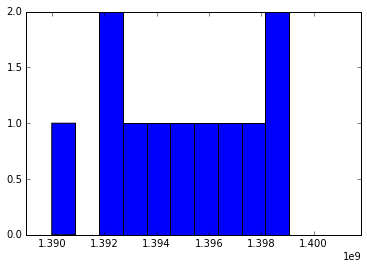

In [350]:
x = np.array(time_spre[:])
plt.hist(x)
plt.xlim([u_t0,u_tt])
print np.std(x)
print u_tt-u_t0
print np.std(x)/(u_tt-u_t0)

In [316]:
print min(time_spre), u_t0
print max(time_spre), u_tt

1409669100.0 1388994
1417662000.0 1417745


In [308]:
u_tt - u_t0

28732500000

In [232]:
x = []
for u, locs in user_states_time_dist.items():
    for loc, time_dist in locs.items():
        x.append(circmean(time_dist))

In [297]:
x

array([  1.41046920e+09])

(array([ 34.,  22.,  17.,   3.,   3.,   3.,   2.,   1.,   1.,   2.,   4.,
          2.,   3.,   1.,   0.,   3.,   2.,   2.,   2.,   0.,   2.,   4.,
          9.,  29.]),
 array([  1.07316678e-02,   1.00762925e+00,   2.00452683e+00,
          3.00142441e+00,   3.99832199e+00,   4.99521957e+00,
          5.99211715e+00,   6.98901473e+00,   7.98591231e+00,
          8.98280989e+00,   9.97970747e+00,   1.09766050e+01,
          1.19735026e+01,   1.29704002e+01,   1.39672978e+01,
          1.49641954e+01,   1.59610929e+01,   1.69579905e+01,
          1.79548881e+01,   1.89517857e+01,   1.99486833e+01,
          2.09455808e+01,   2.19424784e+01,   2.29393760e+01,
          2.39362736e+01]),
 <a list of 24 Patch objects>)

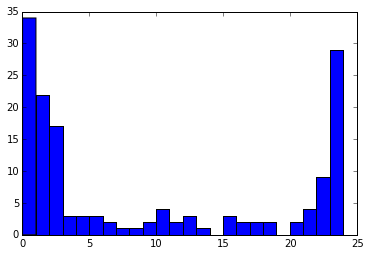

In [233]:
plt.hist(x,bins=24)

In [234]:
#np.array(df_stop_locations[df_stop_locations['user'] == 10][['lat','lon']])

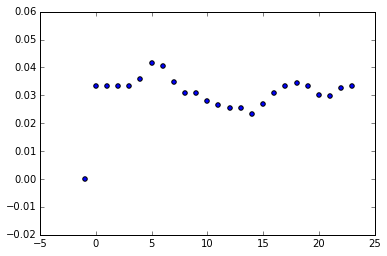

In [235]:
x = [i[0] for i in time_dist.items()]
y = [i[1] for i in time_dist.items()]
plt.scatter(x,y)


In [393]:
pd.DataFrame(np.array(X_u))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000868,0.001735,0.000868,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001735,0.001735,0.001735,0.001735,0.000868,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000434,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.001302,0.001735,0.001735,0.001735,0.001735,0.001735,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.024295,0.024295,0.024295,0.024295,0.026030,0.026030,0.023861,0.014751,0.008677,0.009544,...,0.006941,0.008243,0.016052,0.021258,0.020824,0.023861,0.024295,0.024295,0.024295,0.024295
7,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.003471,0.002169,...,0.005206,0.005206,0.004772,0.003471,0.001302,0.002169,0.002169,0.003471,0.003471,0.003471
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000434,0.005206,0.016920,0.016052,...,0.012581,0.011280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [387]:
time_hist

defaultdict(<type 'int'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0004338394793926247, 7: 0.005206073752711497, 8: 0.016919739696312365, 9: 0.016052060737527116, 10: 0.009544468546637744, 11: 0.0013015184381778742, 12: 0.011713665943600867, 13: 0.011713665943600867, 14: 0.012581344902386117, 15: 0.011279826464208243, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, -1: 0.0})

In [381]:
obs_time_hist

KeyError: 0

In [363]:
tmp['delta'] = tmp.departure - tmp.arrival

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [365]:
sum(tmp['delta'])

2074500

In [35]:
print dt.fromtimestamp(1388615400  )
print dt.fromtimestamp(1388668500  )
print dt.fromtimestamp(1388619000)

2014-01-01 22:30:00
2014-01-02 13:15:00
2014-01-01 23:30:00


In [13]:
df_stop_locations

,arrival,departure,label,lat,lon,timestamp,user
0,1388538000,1388603700,1,55.744777,12.546418,1388541600000,784
1,1388605500,1388614500,29,55.711430,12.565539,1388609100000,784
2,1388615400,1388668500,1,55.744776,12.546420,1388619000000,784
3,1388669400,1388671200,23,55.745909,12.540880,1388673000000,784
4,1388672100,1388687400,1,55.744777,12.546417,1388675700000,784
5,1388690100,1388762100,1,55.744725,12.546381,1388693700000,784
6,1388765700,1388824200,1,55.744777,12.546420,1388769300000,784
7,1388826000,1388829600,56,55.810956,12.514193,1388829600000,784
8,1388835000,1388837700,20,55.717446,12.442254,1388838600000,784
9,1388840400,1388842200,43,55.676556,12.547488,1388844000000,784


In [78]:
sample = {'arrival': 1389381300.0,
  'coordinates': (55.643132199999997, 11.955254999999999),
  'duration': 3600.0}

In [328]:
def bin_24(start, duration):
    bins = [h*3600 for h in range(24)]
    vals = [x%86400 for x in xrange(int(start),int(start+duration),1)]
    return dict((k-1,v) for k,v in Counter(np.digitize(vals,bins)).items())

In [330]:
print bin_24(sample['arrival'], sample['duration'])

{19: 2700, 20: 900}


In [322]:
print dt.fromtimestamp(sample['arrival'])
print dt.fromtimestamp(sample['arrival']+sample['duration'])

2014-01-10 19:15:00
2014-01-10 20:15:00


In [250]:
print dt.fromtimestamp(start)
print dt.fromtimestamp(0)

2014-01-02 00:53:20
1970-01-01 00:00:00


In [305]:
start, duration = 1388624000, 9000
(start%86400/3600*3600 + 3600) - start%86400

400

In [306]:
inp = [x%86400 for x in xrange(start,start+duration,1)]

In [307]:
bins = [h*3600 for h in range(24)]

In [308]:
Counter(np.digitize(inp,bins))

Counter({2: 3600, 3: 3600, 4: 1400, 1: 400})

In [303]:
from collections import Counter